# **Libraries**


In [ ]:
import pandas as pd
import numpy as np
import os
import io
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler , MinMaxScaler , PolynomialFeatures , LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest , mutual_info_classif , mutual_info_regression , f_regression , chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC , SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix , classification_report , mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
import xgboost as xgb

# **Pipline Code**


**Data Collection**


- **Load_Data Method** -> return the data frame \

- **Information_of_data** \
   a. make sure all null values has the value of np.nan to handle it later \

  b. print all information about data \

  c. seperate the data into categorical and numerical data \

- **split data into features and target columns**


In [83]:
def Load_Data(path):
  data_frame = pd.read_csv(path)
  return data_frame



def Information_of_data(data_frame):
  null_patterns = ["", "NA", "NULL", "NaN", "nan", "None", " ", "N/A", "n/a", "?", "-"]
  data_frame.replace(null_patterns, np.nan, inplace=True)

  print("First 5 rows in dataset")
  print(data_frame.head())
  print("Data Info")
  data_frame.info()
  print('\nData Description')
  print(data_frame.describe())
  print('Total Null Values')
  print(data_frame.isnull().sum().sum())
  print("Data Types of Columns")
  print(data_frame.dtypes)

  object_column_names = data_frame.select_dtypes(include=['object']).columns
  int_float_column_names = data_frame.select_dtypes(include=['float' , 'int']).columns
  null_int_float_column_values = data_frame[int_float_column_names].isnull().sum()
  null_object_column_values = data_frame[object_column_names].isnull().sum()

  return object_column_names , null_object_column_values , int_float_column_names , null_int_float_column_values



def Split_Data_Into_Features_And_Target(data_frame , target_column=None):
  if target_column is None:
    target_column = data_frame.columns[-1]

  features = data_frame.drop(columns=[target_column])
  target = data_frame[target_column]

  return features, target

**Data Preprocessing**


- **Rest_Number_Of_Features_After_Deletion Method** \
  return the number of deleted features that have null values greater than the limit that I specified \
   \

- **Handle_Missing_Values_For_Categorical_Columns** \
  using mode instead \
   \

- **Handle_Missing_Values_For_Numeric_Columns** \

a. using mean instead if the column is summetric \

b. using median instead if the column is skewed \
 \

- **Handle_Categorical_Data** \
  using label encoding or one hot encoding (I choose) \
   \

- **Scaling_Data** \

a. standard scalar \

b. min max scalar \
 \

- **Implement_Feature_Selection** \

a. correlation matrix \

b. delete the columns that have less effection on output than a specific value \
 \

-**handle_imbalance** \
using smote or random under sample


In [84]:
# Missing Values

def Rest_Number_Of_Features_After_Deletion( null_int_float_column_values , null_object_column_values , limit_value_of_null_column):
  deletion_count = 0
  for col, null_count in null_int_float_column_values.items():
      if null_count > limit_value_of_null_column:
          deletion_count += 1
          print(f"Marked for deletion - Numerical: {col} ({null_count} nulls)")

  for col, null_count in null_object_column_values.items():
      if null_count > limit_value_of_null_column:
          deletion_count += 1
          print(f"Marked for deletion - Categorical: {col} ({null_count} nulls)")

  return deletion_count


def Handle_Missing_Values_For_Categorical_Columns(object_column_names , data_frame):
  for column in object_column_names:
    if data_frame[column].isnull().sum() != 0:
      # if data_frame[column].isnull().sum() < 300000:
      try:
          mode_value = data_frame[column].mode()[0]
          data_frame[column] = data_frame[column].fillna(mode_value)
      except:
          data_frame[column] = data_frame[column].fillna("MISSING")
          data_frame[column] = data_frame[column].fillna(mode_value)
      # else:
      #   data_frame = data_frame.dropna(subset = [column])
  return data_frame


def Handle_Missing_Values_For_Numeric_Columns(int_float_column_names , data_frame):
  for column in int_float_column_names:
    if data_frame[column].isnull().sum() != 0:
      # if data_frame[column].isnull().sum() < 300000:
      skewness = data_frame[column].skew()
      if abs(skewness) > 0.5:
        fill_value = data_frame[column].median()
      else:
        fill_value = data_frame[column].mean()
      data_frame[column].fillna(fill_value, inplace=True)
      print(f"""
      Column '{column}': Skewness = {skewness:.2f}
      Filled with {'median' if abs(skewness) > 0.5 else 'mean'}
      """)
      # else:
      #   data_frame = data_frame.dropna(subset = [column])
  return data_frame



# Categorical Data

def Handle_Categorical_Data(object_column_names, data_frame, encoding_type):
    if encoding_type == 'label':
        encoder = LabelEncoder()
        return data_frame[object_column_names].apply(encoder.fit_transform)
    elif encoding_type == 'onehot':
        return pd.get_dummies(data_frame, columns=object_column_names, dtype=int)
    else:
        print("Encoding type must be 'label' or 'onehot'")



# Scaling Data

def Scaling_Data(data_frame , features_train , features_test , features , target):
  # Plot_Numerical_Data(data_frame, 'scatter', None, (10, 6), 5)

  standard_scalar = StandardScaler()
  scaled_train_features_using_standard_scalar = standard_scalar.fit_transform(features_train)
  scaled_test_features_using_standard_scalar = standard_scalar.transform(features_test)
  min_max_scalar = MinMaxScaler()
  scaled_train_features_using_min_max_scalar = min_max_scalar.fit_transform(features_train)
  scaled_test_features_using_min_max_scalar = min_max_scalar.transform(features_test)

  return scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar



# feature selection

def Implement_Feature_Selection(data_frame, target_column_name, threshold=0.1):
    correlation_matrix = data_frame.corr()

    target_corr = correlation_matrix[target_column_name].abs().sort_values(ascending=False)

    low_corr_features = target_corr[target_corr < threshold].index.tolist()

    if target_column_name in low_corr_features:
        low_corr_features.remove(target_column_name)

    updated_df = data_frame.drop(columns=low_corr_features)

    plt.figure(figsize=(12, 8))
    sns.heatmap(updated_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Updated Correlation Matrix (After Feature Selection)")
    plt.show()

    if low_corr_features:
        print(f"\nDropped features (correlation < {threshold}): {low_corr_features}")
    else:
        print("\nNo features were dropped (all correlations ≥ threshold).")

    return updated_df



# Handle Imbalanced Data
def handle_imbalance(features, target, type_of_handling):
  if type_of_handling == 'smote':
      return SMOTE().fit_resample(features , target)
  elif type_of_handling == 'undersample':
      return RandomUnderSampler().fit_resample(features , target)
  else:
      raise ValueError("Method must be 'smote' or 'undersample'")

**Data Visualization**


- **Plot_Numerical_Data** \
   \
  a. Histogram \
  b. Box Plot \
  c. Scatter Plot \
  d. Pair \
  e. Correlation Matrix \
   \

- **Plot_Categorical_Data** \
   \
  a. Count Graph \
  b. Pie Chart \
  c. Bar Chart \
  d. Heat Map


In [85]:
def Plot_Numerical_Data(df, plot_type='all', columns=None, figsize=(10, 6), plots_per_row=3):
    """
    Enhanced numerical data visualization with grid layout for all plot types

    Parameters:
    -----------
    df : DataFrame
        Input data
    plot_type : str
        Type of plot ('hist', 'box', 'scatter', 'pair', 'corr', 'all')
    columns : list
        Specific columns to plot
    figsize : tuple
        Base figure size (will be scaled for grid layouts)
    plots_per_row : int
        Number of plots per row in grid layouts
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    if columns:
        numeric_cols = [col for col in columns if col in numeric_cols]

    if len(numeric_cols) == 0:
        print("⚠️ No numeric columns available")
        return

    # Plot all types if requested
    if plot_type == 'all':
        plot_types = ['hist', 'box', 'scatter', 'pair', 'corr']
        for p_type in plot_types:
            Plot_Numerical_Data(df, p_type, columns, figsize, plots_per_row)
        return

    # Helper function for creating grid layouts
    def create_grid(n_plots, plots_per_row, fig_width=10, fig_height=6):
      if n_plots == 0:
        return None, None, 0

      n_rows = max(1, (n_plots + plots_per_row - 1) // plots_per_row)
      total_plots = n_rows * plots_per_row

      fig, axes = plt.subplots(n_rows , plots_per_row , figsize=(fig_width*plots_per_row , fig_height*n_rows))

      if isinstance(axes, np.ndarray):
          axes = axes.flatten()
      else:
          axes = [axes]

      return fig, axes, n_rows

    # Histograms with grid layout
    if plot_type == 'hist':
        print("\n📊 Histograms")
        fig, axes, n_rows = create_grid(len(numeric_cols), plots_per_row, *figsize)

        for i, col in enumerate(numeric_cols):
            sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')

        # Hide empty subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    # Boxplots with grid layout
    elif plot_type == 'box':
        print("\n📦 Boxplots")
        fig, axes, n_rows = create_grid(len(numeric_cols), plots_per_row, *figsize)

        for i, col in enumerate(numeric_cols):
            sns.boxplot(x=df[col], ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel('')

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    # Scatter plots (matrix layout)
    elif plot_type == 'scatter' and len(numeric_cols) >= 2:
        print("\n🔵 Scatter Plot Matrix")
        # Create all pairwise combinations
        combinations = [(x, y) for i, x in enumerate(numeric_cols)
                       for j, y in enumerate(numeric_cols) if i < j]

        fig, axes, n_rows = create_grid(len(combinations), plots_per_row, *figsize)

        for i, (x_col, y_col) in enumerate(combinations):
            sns.scatterplot(x=df[x_col], y=df[y_col], ax=axes[i])
            axes[i].set_title(f'{x_col} vs {y_col}')

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    # Pair plot (uses seaborn's built-in grid)
    elif plot_type == 'pair' and len(numeric_cols) >= 2:
        print("\n🔄 Pair Plot")
        sns.pairplot(df[numeric_cols])
        plt.show()

    # Correlation matrix
    elif plot_type == 'corr' and len(numeric_cols) >= 2:
        print("\n🧮 Correlation Matrix")
        plt.figure(figsize=(max(8, len(numeric_cols)), max(6, len(numeric_cols)//2)))
        corr = df[numeric_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Correlation Matrix')
        plt.show()

    else:
        print("⚠️ Invalid plot type or insufficient columns")






def Plot_Categorical_Data(df, plot_type='all', columns=None, figsize=(10, 6),
                        max_categories=15):
    """
    Simplified categorical data visualization without grid layout

    Parameters:
    -----------
    df : DataFrame
        Input data
    plot_type : str
        Type of plot ('count', 'pie', 'bar', 'heatmap', 'all')
    columns : list
        Specific columns to plot
    figsize : tuple
        Base figure size
    max_categories : int
        Maximum categories to display per plot
    """
    # Get categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if columns:
        categorical_cols = [col for col in columns if col in categorical_cols]

    if len(categorical_cols) == 0:
        print("⚠️ No categorical columns available")
        return

    # Plot all types if requested
    if plot_type == 'all':
        plot_types = ['count', 'pie', 'bar', 'heatmap']
        for p_type in plot_types:
            Plot_Categorical_Data(df, p_type, columns, figsize, max_categories)
        return

    # Filter valid columns
    valid_cols = [col for col in categorical_cols
                 if (df[col].nunique() <= max_categories) and
                 (not df[col].isnull().all()) and
                 (df[col].nunique() > 0)]

    if not valid_cols:
        print(f"⚠️ No valid columns with ≤ {max_categories} categories")
        return

    # Count plots
    if plot_type == 'count':
        print("\n📊 Count Plots")
        for col in valid_cols:
            plt.figure(figsize=figsize)
            sns.countplot(y=col, data=df, order=df[col].value_counts().index)
            plt.title(f'Distribution of {col}')
            plt.tight_layout()
            plt.show()

    # Bar plots
    elif plot_type == 'bar':
        print("\n📊 Bar Plots")
        for col in valid_cols:
            plt.figure(figsize=figsize)
            df[col].value_counts().plot.bar()
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    # Pie charts
    elif plot_type == 'pie':
        print("\n🥧 Pie Charts")
        for col in valid_cols:
            plt.figure(figsize=figsize)
            df[col].value_counts().plot.pie(autopct='%1.1f%%')
            plt.title(f'Distribution of {col}')
            plt.ylabel('')
            plt.tight_layout()
            plt.show()

    # Heatmap for categorical relationships
    elif plot_type == 'heatmap':
        print("\n🌡️ Categorical Heatmaps")
        if len(valid_cols) >= 2:
            # Create all valid pairwise combinations
            combinations = [(x, y) for i, x in enumerate(valid_cols)
                           for j, y in enumerate(valid_cols) if i < j]

            for col1, col2 in combinations:
                plt.figure(figsize=figsize)
                pd.crosstab(df[col1], df[col2]).plot(kind='bar', stacked=True)
                plt.title(f'{col1} by {col2}')
                plt.legend(title=col2, bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
        else:
            print(f"⚠️ Need at least 2 valid columns with ≤ {max_categories} categories for heatmap")

    else:
        print("⚠️ Invalid plot type")

# Example usage:
# Plot_Categorical_Data(df, plot_type='count')
# Plot_Categorical_Data(df, plot_type='all')

**Model Training**


- **Split_Data_Into_Train_And_Test** \
   \

- **Train Models** \

  a. Linear Regression \
   b. Logistic Regression \
   c. Naive Bais \
   d. Support Machine Learning \
   e. K Nearest Neighbor \
   f. Decision Tree \
   g. Random Forest \
   h. XG Boost \


In [86]:
# Method of splitting data into train and test data
def Split_Data_Into_Train_And_Test(features , target , ts = 0.2 , rs = 0):
    features_train, features_test, target_train, target_test = train_test_split(features , target , test_size = ts, random_state = rs)
    return features_train, features_test, target_train, target_test



# Method of Training the model using specific Algorithm

# linear regression
def Train_Model_using_Linear_Regression(features_train , target_train):

    model = LinearRegression()
    model.fit(features_train, target_train)
    print("Model training completed.")
    return model


# logistic regression
def Train_Model_using_Logistic_Regression(features_train , target_train):

    model = LogisticRegression()
    model.fit(features_train, target_train)
    print("Model training completed.")
    return model


# naive bayes
def Train_Model_using_Naive_Bayes(features_train , target_train):

    model = GaussianNB()
    model.fit(features_train, target_train)
    print("Model training completed.")
    return model


# support vector machine for classification and regression
def Train_Model_using_Support_Vector_Machine(features_train , target_train , type_of_algorithm):

  if type_of_algorithm == 'regression':
    model = SVR()
    model.fit(features_train, target_train)
    print("Model training completed.")

  elif type_of_algorithm == 'classification':
    model = SVC()
    model.fit(features_train, target_train)
    print("Model training completed.")

  else:
    print("Type of SVM Algorithm is Invalid.")

  return model


# k nearest neighbour for classification and regression
def Train_Model_using_K_Nearest_Neighbour(features_train , target_train , type_of_algorithm , n_neighbors):

  if type_of_algorithm == 'regression':
    model = KNeighborsRegressor(
        n_neighbors = n_neighbors
    )
    model.fit(features_train, target_train)
    print("Model training completed.")

  elif type_of_algorithm == 'classification':
    model = KNeighborsClassifier(
        n_neighbors = n_neighbors
    )
    model.fit(features_train, target_train)
    print("Model training completed.")

  else:
    print("Type of SVM Algorithm is Invalid.")

  return model


# decision tree for classification and regression
def Train_Model_using_Decision_Tree(features_train , target_train , type_of_algorithm , max_depth):

  if type_of_algorithm == 'regression':
    model = DecisionTreeRegressor(
        criterion = 'squared_error' ,
        max_depth = max_depth
    )
    model.fit(features_train, target_train)
    print("Model training completed.")

  elif type_of_algorithm == 'classification':
    model = DecisionTreeClassifier(
        criterion = 'gini' ,
        max_depth = max_depth
    )
    model.fit(features_train, target_train)
    print("Model training completed.")

  else:
    print("Type of SVM Algorithm is Invalid.")

  return model

# random forest for classification and regression
def Train_Model_using_Random_Forest(features_train , target_train , type_of_algorithm , max_depth , n_estimators):

  if type_of_algorithm == 'regression':
    model = RandomForestRegressor(
        max_depth = max_depth ,
        n_estimators = n_estimators
    )
    model.fit(features_train, target_train)
    print("Model training completed.")

  elif type_of_algorithm == 'classification':
    model = RandomForestClassifier(
        max_depth = max_depth ,
        n_estimators = n_estimators
    )
    model.fit(features_train, target_train)
    print("Model training completed.")

  else:
    print("Type of SVM Algorithm is Invalid.")

  return model

# xgboost for classification and regression
def Train_Model_using_XGBoost(features_train , target_train , type_of_algorithm , max_depth , n_estimators , learning_rate):

  if type_of_algorithm == 'regression':
    model = xgb.XGBRegressor(
        n_estimators = n_estimators ,
        learning_rate = learning_rate ,
        max_depth = max_depth
    )
    model.fit(features_train, target_train)
    print("Model training completed.")

  elif type_of_algorithm == 'classification':
    model = xgb.XGBClassifier(
        n_estimators = n_estimators ,
        learning_rate = learning_rate ,
        max_depth = max_depth
    )
    model.fit(features_train, target_train)
    print("Model training completed.")

  else:
    print("Type of SVM Algorithm is Invalid.")

  return model

**Model Evaluation**


- **Evaluation For Train And Test** \

a. Classification \

    - Accuracy Score \
    - Precision \
    - Recall \
    - F1 Score \
    - Confusion Matrix \
    - Classification Report \

\

b. Regression \

    - R2 Score \
    - Mean Absolute Error \
    - Mean Squared Error \


In [87]:

# Mehod for Evaluation to classification and regression
def Evaluation_For_Train_And_Test(model , features_train , features_test , target_train , target_test , type_of_data):
  target_train_predict = model.predict(features_train)
  target_test_predict = model.predict(features_test)

  if type_of_data == 'classification':
    results = {
      'Train': {
          'Accuracy': accuracy_score(target_train, target_train_predict),
          'Precision': precision_score(target_train, target_train_predict),
          'Recall': recall_score(target_train, target_train_predict),
          'F1-Score': f1_score(target_train, target_train_predict)
          # 'Confusion Matrix': confusion_matrix(target_train, target_train_predict),
          # 'Classification Report': classification_report(target_train, target_train_predict, output_dict=True)
      },
      'Test': {
          'Accuracy': accuracy_score(target_test, target_test_predict),
          'Precision': precision_score(target_test, target_test_predict),
          'Recall': recall_score(target_test, target_test_predict),
          'F1-Score': f1_score(target_test, target_test_predict)
          # 'Confusion Matrix': confusion_matrix(target_test, target_test_predict),
          # 'Classification Report': classification_report(target_test, target_test_predict, output_dict=True)
      }
  } # , average='weighted'
  elif type_of_data == 'regression':
    results = {
      'Train': {
          'R2 Score': r2_score(target_train, target_train_predict),
          'Mean Absolute Erorr': mean_absolute_error(target_train, target_train_predict),
          'Mean Squared Error': mean_squared_error(target_train, target_train_predict)
      },
      'Test': {
          'Accuracy': r2_score(target_test, target_test_predict),
          'Mean Absolute Erorr': mean_absolute_error(target_test, target_test_predict),
          'Mean Squared Error': mean_squared_error(target_test, target_test_predict)
      }
  }
  else:
    print("Type of Data is Invalid.")
  return results

**Saving & Loading Data**


- **Save_Model** \

- **Load_Model**


In [88]:
# Method of Saving The Model
def Save_Model(model, path):
    joblib.dump(model, path)
    print(f"Model saved")


# Method of Loading The Model
def Load_Model(path):
    if os.path.exists(path):
        return joblib.load(path)
    else:
        raise FileNotFoundError(f"No model found at {path}")

# **League of Legends Addiction Predictor**

**AddictLoL: Machine Learning Classification of Gaming Addiction in League of Legends**


**Overview of the Dataset**


The dataset contains detailed match records from League of Legends with a binary classification target indicating whether the player exhibits addictive behavior (Addiction). Key components include:

- Match Identifiers: gameId, creationTime, seasonId

- Match Statistics: gameDuration, winner, firstBlood, firstTower, etc.

- Champion Data: Champions selected for both teams (t1_champ1id to t2_champ5id) with their roles

- Summoner Spells: Spells used by each player

- Ban Information: Champions banned by each team

- Performance Metrics: Tower kills, inhibitor kills, dragon kills, etc.

- Behavioral Features: total_matches, daily_matches

- Target Variable: addiction (True/False)


**Detailed Data Analysis**


1.  Data Characteristics Approximately 400 match records \

    Around 200 features per match

    Time span covering multiple dates (visible in date column)

    Season 9 matches (seasonId = 9)

2.  Target Variable \

          Binary classification problem (Addicted vs. Non-addicted)

          Potential class imbalance to investigate

          Requires clear definition of what constitutes "addiction" in this context

    \

3.  Feature Categories \
    \
    a. Temporal Features:

                        Match timestamp (creationTime)

                        Game duration (gameDuration)

                        Calendar date (date) \

    \
    b. Match Outcome Features:

                        First blood/tower/inhibitor/baron/dragon/herald indicators

                        Team kill statistics

                        Objective control metrics \

    \
    C. Champion-Related Features:

                        Champion IDs and names for all 10 players

                        Champion roles (Mage, Marksman, etc.)

                        Summoner spell combinations \

    \
    D. Player Behavior Features:

                        Total matches played (total_matches)

                        Daily match frequency (daily_matches)


**Result of Code Alogrithms**


**Decision Tree , All : 100%** \
**XG Boost , All : 100%** \
**Random Forest , Min Max Scalar : 100%** \
**Logistic Regression , Standard Scalar : 99%** \
**Support Vector Machine , Standard Scalar : 97%** \
**Naive Bayes , All : 85%**
**K Nearest Neighbour , Standard Scalar : 83%** \


**Data Information** \
 \
 RangeIndex: 51490 entries, 0 to 51489 \
 Columns: 105 entries, gameId to addiction \
 dtypes: bool(1), int64(63), object(41)


# **Project Implementation**


In [89]:
MODEL_PATH = 'model.pkl'
DATA_PATH = 'final_ready_data.csv'
TEST_SIZE = 0.2
RANDOM_STATE = 0

data_frame = Load_Data(DATA_PATH)
object_column_names , null_object_column_values , int_float_column_names , null_int_float_column_values = Information_of_data(data_frame)


First 5 rows in dataset
       gameId   creationTime  gameDuration  seasonId  winner  firstBlood  \
0  3326086514  1504279457970          1949         9       1           2   
1  3229566029  1497848803862          1851         9       1           1   
2  3327363504  1504360103310          1493         9       1           2   
3  3326856598  1504348503996          1758         9       1           1   
4  3330080762  1504554410899          2094         9       1           2   

   firstTower  firstInhibitor  firstBaron  firstDragon  ...  \
0           1               1           1            1  ...   
1           1               1           0            1  ...   
2           1               1           1            2  ...   
3           1               1           1            1  ...   
4           1               1           1            1  ...   

   t2_champ3_sum1_name  t2_champ3_sum2_name  t2_champ4_sum1_name  \
0                Ghost                Flash               Ignite   
1   

In [90]:
rest_number_of_features = Rest_Number_Of_Features_After_Deletion( null_int_float_column_values , null_object_column_values , 17000)
print(f"\n\nNumber of features that will be Deleted [ The rest of features ] , The Whole Number of Features = 18 :  {rest_number_of_features}")

data_frame = Handle_Missing_Values_For_Numeric_Columns(int_float_column_names , data_frame)
data_frame = Handle_Missing_Values_For_Categorical_Columns(object_column_names , data_frame)
print(f"Null Values : {data_frame.isnull().sum().sum()}")
print("Has Been Handled\n\n")

data_frame['addiction'] = data_frame['addiction'].astype(int)

data_frame[object_column_names] = Handle_Categorical_Data(object_column_names, data_frame, 'label')
print(f"Categorical Data Has Been Handled :  \n{data_frame.dtypes}\n\n")

features , target = Split_Data_Into_Features_And_Target(data_frame , 'addiction')





Number of features that will be Deleted [ The rest of features ] , The Whole Number of Features = 18 :  0
Null Values : 0
Has Been Handled


Categorical Data Has Been Handled :  
gameId                 int64
creationTime           int64
gameDuration           int64
seasonId               int64
winner                 int64
                       ...  
t2_champ5_sum2_name    int64
total_matches          int64
date                   int64
daily_matches          int64
addiction              int64
Length: 105, dtype: object




In [91]:
# Logistic Regression

features_train, features_test, target_train, target_test = Split_Data_Into_Train_And_Test(features , target , 0.2 , 0)
scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar = Scaling_Data(data_frame , features_train , features_test , features , target)

logistic_regression_standard_scalar = Train_Model_using_Logistic_Regression(scaled_train_features_using_standard_scalar , target_train)
logistic_regression_min_max_scalar = Train_Model_using_Logistic_Regression(scaled_train_features_using_standard_scalar , target_train)

result_logistic_regression_standard = Evaluation_For_Train_And_Test(logistic_regression_standard_scalar , scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , target_train , target_test , 'classification')
result_logistic_regression_min_max = Evaluation_For_Train_And_Test(logistic_regression_min_max_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar , target_train , target_test , 'classification')

print("Logistic Regression Results\n\n")
print("\tStandard Scalar Results: \n")

print(f"\t\tTrain Results: \n")
for key, value in result_logistic_regression_standard['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_logistic_regression_standard['Test'].items():
    print(f"\t\t\t{key}: {value}")


print("\n\tMin Max Scalar Results: \n")
for key, value in result_logistic_regression_min_max['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_logistic_regression_min_max['Test'].items():
    print(f"\t\t\t{key}: {value}")


Model training completed.
Model training completed.
Logistic Regression Results


	Standard Scalar Results: 

		Train Results: 

			Accuracy: 0.9980335987570402
			Precision: 0.9982531145129407
			Recall: 0.9980237154150198
			F1-Score: 0.998138401783457
		Test Results: 

			Accuracy: 0.9972810254418334
			Precision: 0.9968692449355433
			Recall: 0.99797197640118
			F1-Score: 0.9974203058780173

	Min Max Scalar Results: 

			Accuracy: 0.5282093610409788
			Precision: 0.5282093610409788
			Recall: 1.0
			F1-Score: 0.6912787926926132
		Test Results: 

			Accuracy: 0.5267042144105651
			Precision: 0.5267042144105651
			Recall: 1.0
			F1-Score: 0.6899885510749268


In [92]:
# Support Vector Machine

features_train, features_test, target_train, target_test = Split_Data_Into_Train_And_Test(features , target , 0.1 , 0)
scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar = Scaling_Data(data_frame , features_train , features_test , features , target)

Support_Vector_Machine_standard_scalar = Train_Model_using_Support_Vector_Machine(scaled_train_features_using_standard_scalar , target_train , 'classification')
Support_Vector_Machine_min_max_scalar = Train_Model_using_Support_Vector_Machine(scaled_train_features_using_min_max_scalar , target_train , 'classification')


Model training completed.
Model training completed.


In [93]:
result_Support_Vector_Machine_standard_scalar= Evaluation_For_Train_And_Test(Support_Vector_Machine_standard_scalar , scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , target_train , target_test , 'classification')
result_Support_Vector_Machine_min_max_scalar = Evaluation_For_Train_And_Test(Support_Vector_Machine_min_max_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar , target_train , target_test , 'classification')

print("Support Vector Machine Results\n\n")
print("\tStandard Scalar Results: \n")

print(f"\t\tTrain Results: \n")
for key, value in result_Support_Vector_Machine_standard_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_Support_Vector_Machine_standard_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


print("\n\tMin Max Scalar Results: \n")
for key, value in result_Support_Vector_Machine_min_max_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_Support_Vector_Machine_min_max_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


Support Vector Machine Results


	Standard Scalar Results: 

		Train Results: 

			Accuracy: 0.9969789171575927
			Precision: 0.9971324402933104
			Recall: 0.9971324402933104
			F1-Score: 0.9971324402933104
		Test Results: 

			Accuracy: 0.9718391920761313
			Precision: 0.9719626168224299
			Recall: 0.975821003247925
			F1-Score: 0.9738879884746984

	Min Max Scalar Results: 

			Accuracy: 0.9733928918236551
			Precision: 0.9751927177300311
			Recall: 0.9742738929171275
			F1-Score: 0.9747330887928032
		Test Results: 

			Accuracy: 0.9432899592153816
			Precision: 0.950563431479462
			Recall: 0.9437026344280043
			F1-Score: 0.9471206084751902


In [94]:
# K Nearest Neighbour

features_train, features_test, target_train, target_test = Split_Data_Into_Train_And_Test(features , target , 0.1 , 0)
scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar = Scaling_Data(data_frame , features_train , features_test , features , target)

K_Nearest_Neighbour_standard_scalar = Train_Model_using_K_Nearest_Neighbour(scaled_train_features_using_standard_scalar , target_train , 'classification' , 200)
K_Nearest_Neighbour_min_max_scalar = Train_Model_using_K_Nearest_Neighbour(scaled_train_features_using_min_max_scalar , target_train , 'classification' , 200)

result_K_Nearest_Neighbour_standard_scalar= Evaluation_For_Train_And_Test(K_Nearest_Neighbour_standard_scalar , scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , target_train , target_test , 'classification')
result_K_Nearest_Neighbour_min_max_scalar = Evaluation_For_Train_And_Test(K_Nearest_Neighbour_min_max_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar , target_train , target_test , 'classification')

print("K Nearest Neighbour Results\n\n")
print("\tStandard Scalar Results: \n")

print(f"\t\tTrain Results: \n")
for key, value in result_K_Nearest_Neighbour_standard_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_K_Nearest_Neighbour_standard_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


print("\n\tMin Max Scalar Results: \n")
print(f"\t\tTrain Results: \n")
for key, value in result_K_Nearest_Neighbour_min_max_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_K_Nearest_Neighbour_min_max_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


Model training completed.
Model training completed.
K Nearest Neighbour Results


	Standard Scalar Results: 

		Train Results: 

			Accuracy: 0.8406378800630112
			Precision: 0.8712279783708355
			Recall: 0.8184425054278809
			F1-Score: 0.8440107302029867
		Test Results: 

			Accuracy: 0.8389978636628471
			Precision: 0.8760650658404338
			Recall: 0.8163118007939372
			F1-Score: 0.8451335699607697

	Min Max Scalar Results: 

		Train Results: 

			Accuracy: 0.7834315185257116
			Precision: 0.8000667974783952
			Recall: 0.7850559174142805
			F1-Score: 0.7924902820279547
		Test Results: 

			Accuracy: 0.7826762478151097
			Precision: 0.8054733727810651
			Recall: 0.7859978347167088
			F1-Score: 0.7956164383561644


In [95]:
# Decision Tree

features_train, features_test, target_train, target_test = Split_Data_Into_Train_And_Test(features , target , 0.25 , 1)
scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar = Scaling_Data(data_frame , features_train , features_test , features , target)

decision_tree_standard_scalar = Train_Model_using_Decision_Tree(scaled_train_features_using_standard_scalar , target_train , 'classification' , 5)
decision_tree_min_max_scalar = Train_Model_using_Decision_Tree(scaled_train_features_using_min_max_scalar , target_train , 'classification' , 5)

result_decision_tree_standard_scalar= Evaluation_For_Train_And_Test(decision_tree_standard_scalar , scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , target_train , target_test , 'classification')
result_decision_tree_min_max_scalar = Evaluation_For_Train_And_Test(decision_tree_min_max_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar , target_train , target_test , 'classification')

print("Decision Tree Results\n\n")
print("\tStandard Scalar Results: \n")

print(f"\t\tTrain Results: \n")
for key, value in result_decision_tree_standard_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_decision_tree_standard_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


print("\n\tMin Max Scalar Results: \n")
print(f"\t\tTrain Results: \n")
for key, value in result_decision_tree_min_max_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_decision_tree_min_max_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


Model training completed.
Model training completed.
Decision Tree Results


	Standard Scalar Results: 

		Train Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0
		Test Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0

	Min Max Scalar Results: 

		Train Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0
		Test Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0


In [99]:
# Random Forest

features_train, features_test, target_train, target_test = Split_Data_Into_Train_And_Test(features , target , 0.2 , 1)
scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar = Scaling_Data(data_frame , features_train , features_test , features , target)

random_forest_standard_scalar = Train_Model_using_Random_Forest(scaled_train_features_using_standard_scalar , target_train , 'classification' , 5 , 100)
random_forest_min_max_scalar = Train_Model_using_Random_Forest(scaled_train_features_using_min_max_scalar , target_train , 'classification' , 5 , 100)

result_random_forest_standard_scalar= Evaluation_For_Train_And_Test(random_forest_standard_scalar , scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , target_train , target_test , 'classification')
result_random_forest_min_max_scalar = Evaluation_For_Train_And_Test(random_forest_min_max_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar , target_train , target_test , 'classification')

print("Random Forest Results\n\n")
print("\tStandard Scalar Results: \n")

print(f"\t\tTrain Results: \n")
for key, value in result_random_forest_standard_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_random_forest_standard_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


print("\n\tMin Max Scalar Results: \n")
print(f"\t\tTrain Results: \n")
for key, value in result_random_forest_min_max_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_random_forest_min_max_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


Model training completed.
Model training completed.
Random Forest Results


	Standard Scalar Results: 

		Train Results: 

			Accuracy: 0.9984948533695863
			Precision: 0.9985310319500551
			Recall: 0.9986227160040401
			F1-Score: 0.9985768718725612
		Test Results: 

			Accuracy: 0.9989318314235774
			Precision: 0.9987044234684435
			Recall: 0.9992592592592593
			F1-Score: 0.9989817643247246

	Min Max Scalar Results: 

		Train Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0
		Test Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0


In [97]:
# XGBoost

features_train, features_test, target_train, target_test = Split_Data_Into_Train_And_Test(features , target , 0.2 , 0)
scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar = Scaling_Data(data_frame , features_train , features_test , features , target)

xgboost_standard_scalar = Train_Model_using_XGBoost(scaled_train_features_using_standard_scalar , target_train , 'classification' , 5 , 100 , 0.1)
xgboost_min_max_scalar = Train_Model_using_XGBoost(scaled_train_features_using_min_max_scalar , target_train , 'classification' , 5 , 100 , 0.1)

result_xgboost_standard_scalar= Evaluation_For_Train_And_Test(xgboost_standard_scalar , scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , target_train , target_test , 'classification')
result_xgboost_min_max_scalar = Evaluation_For_Train_And_Test(xgboost_min_max_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar , target_train , target_test , 'classification')

print("XGBoost Results\n\n")
print("\tStandard Scalar Results: \n")

print(f"\t\tTrain Results: \n")
for key, value in result_xgboost_standard_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_xgboost_standard_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


print("\n\tMin Max Scalar Results: \n")
print(f"\t\tTrain Results: \n")
for key, value in result_xgboost_min_max_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_xgboost_min_max_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


Model training completed.
Model training completed.
XGBoost Results


	Standard Scalar Results: 

		Train Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0
		Test Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0

	Min Max Scalar Results: 

		Train Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0
		Test Results: 

			Accuracy: 1.0
			Precision: 1.0
			Recall: 1.0
			F1-Score: 1.0


In [98]:
# Naive Bayes

features_train, features_test, target_train, target_test = Split_Data_Into_Train_And_Test(features , target , 0.15 , 0)
scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar = Scaling_Data(data_frame , features_train , features_test , features , target)

Naive_Bayes_standard_scalar = Train_Model_using_Naive_Bayes(scaled_train_features_using_standard_scalar , target_train)
Naive_Bayes_min_max_scalar = Train_Model_using_Naive_Bayes(scaled_train_features_using_min_max_scalar , target_train)

result_Naive_Bayes_standard_scalar= Evaluation_For_Train_And_Test(Naive_Bayes_standard_scalar , scaled_train_features_using_standard_scalar , scaled_test_features_using_standard_scalar , target_train , target_test , 'classification')
result_Naive_Bayes_min_max_scalar = Evaluation_For_Train_And_Test(Naive_Bayes_min_max_scalar , scaled_train_features_using_min_max_scalar , scaled_test_features_using_min_max_scalar , target_train , target_test , 'classification')

print("Naive Bayes Results\n\n")
print("\tStandard Scalar Results: \n")

print(f"\t\tTrain Results: \n")
for key, value in result_Naive_Bayes_standard_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_Naive_Bayes_standard_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


print("\n\tMin Max Scalar Results: \n")
print(f"\t\tTrain Results: \n")
for key, value in result_Naive_Bayes_min_max_scalar['Train'].items():
    print(f"\t\t\t{key}: {value}")
print(f"\t\tTest Results: \n")
for key, value in result_Naive_Bayes_min_max_scalar['Test'].items():
    print(f"\t\t\t{key}: {value}")


Model training completed.
Model training completed.
Naive Bayes Results


	Standard Scalar Results: 

		Train Results: 

			Accuracy: 0.8514600374720103
			Precision: 0.8449602728898873
			Recall: 0.8798405960322273
			F1-Score: 0.8620477453580901
		Test Results: 

			Accuracy: 0.8557742102537546
			Precision: 0.8483644859813084
			Recall: 0.886474609375
			F1-Score: 0.8670009551098377

	Min Max Scalar Results: 

		Train Results: 

			Accuracy: 0.8514600374720103
			Precision: 0.8449602728898873
			Recall: 0.8798405960322273
			F1-Score: 0.8620477453580901
		Test Results: 

			Accuracy: 0.8557742102537546
			Precision: 0.8483644859813084
			Recall: 0.886474609375
			F1-Score: 0.8670009551098377


**Graphs**


**Numerical Data**


In [100]:
Plot_Numerical_Data(data_frame , 'hist')


📊 Histograms



🧮 Correlation Matrix


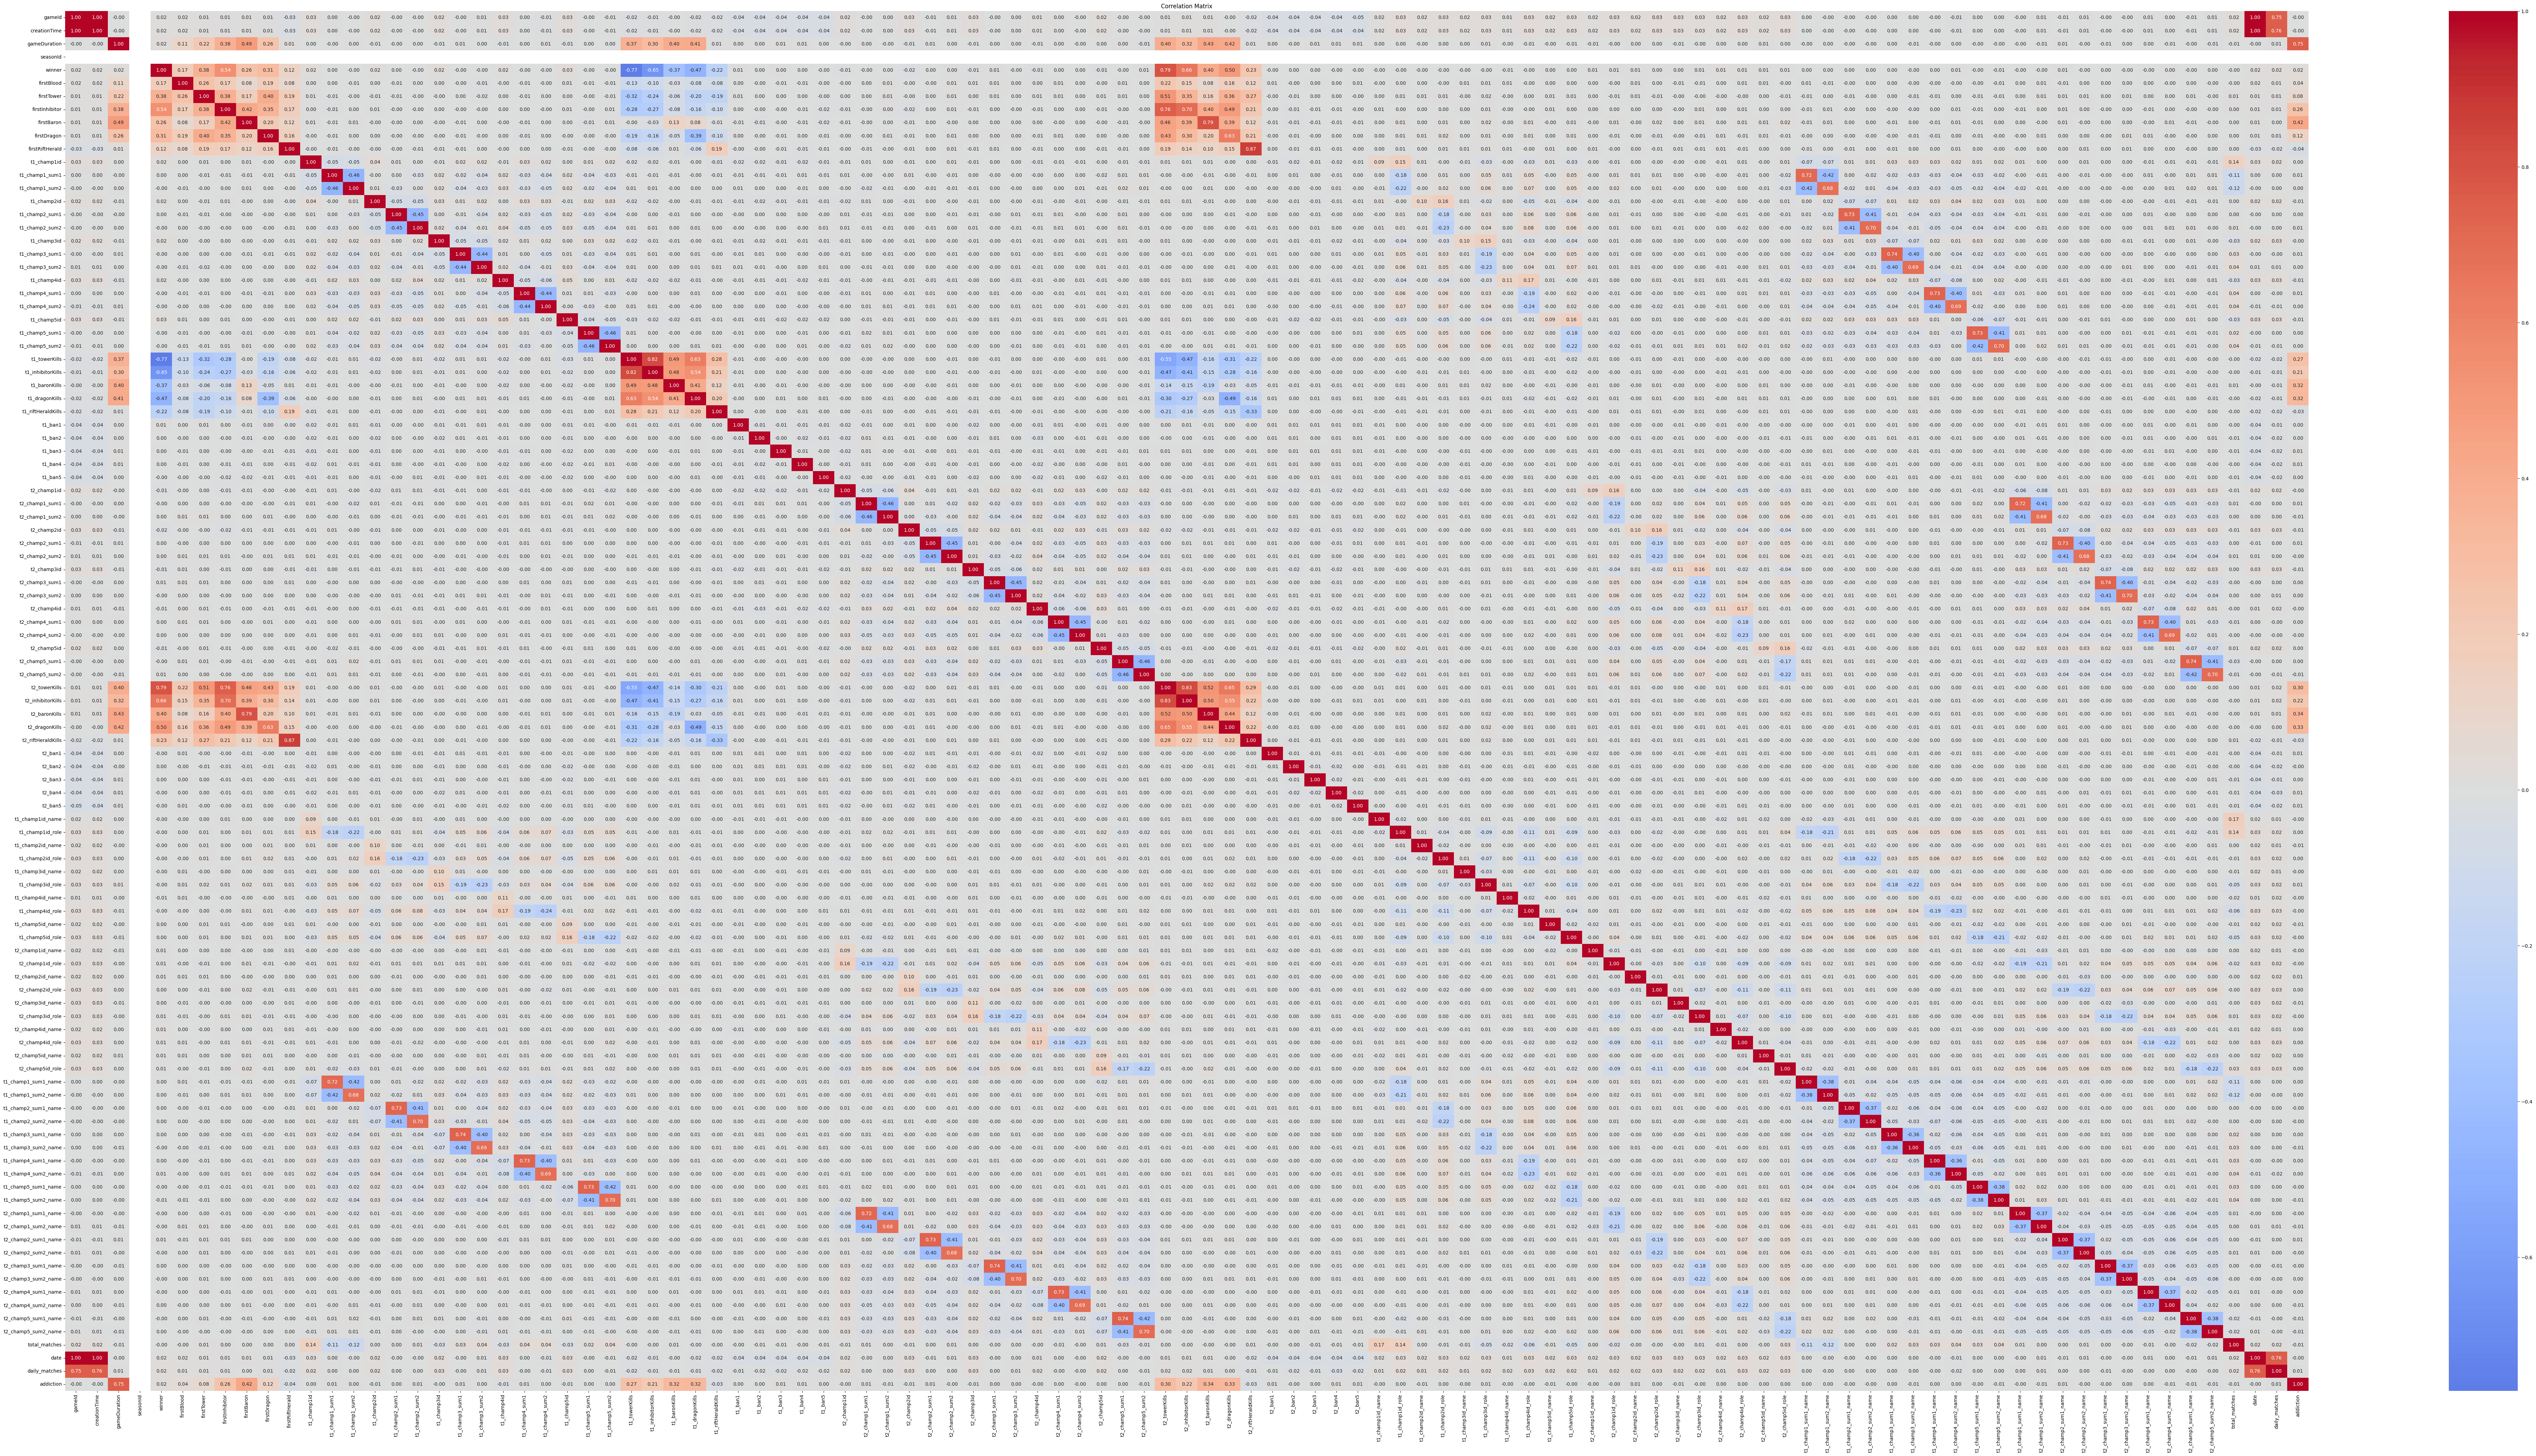

In [101]:
Plot_Numerical_Data(data_frame , 'corr')

In [102]:
Plot_Numerical_Data(data_frame , 'box')


📦 Boxplots


In [ ]:
Plot_Numerical_Data(data_frame , 'scatter')


🔵 Scatter Plot Matrix


In [ ]:
Plot_Numerical_Data(data_frame , 'pair')

**Categorical Data**


In [ ]:
Plot_Categorical_Data(data_frame , 'bar')

In [ ]:
Plot_Categorical_Data(data_frame , 'count')

In [ ]:
Plot_Categorical_Data(data_frame , 'pie')

In [ ]:
Plot_Categorical_Data(data_frame , 'heatmap')